# Data Prep for NMF Projection 
 - Normalization and Harmony
 - NMF projection on CD4 T cells
 - subsetting Non-naive CD4 T cells from CD4 Tcells

In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import anndata
import re
import h5py
import scipy.sparse as scs
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csc_matrix
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import umap
import random
import multiprocessing
random.seed(123)
from joblib import Parallel, delayed
import warnings
import os
import gc
import math
from PIL import Image
from PIL import ImageDraw
import sc_toolbox as sct
import scanpy.external as sce

/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



### Following the normalization based on the NMF paper

In [2]:
subset_a_dc=sc.read("/home/jupyter/ALTRA_ANALYSIS/Deep_clean/certpro/py_files/ALTRA_Certpro_CD4_Tcell.h5ad")

/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [3]:
subset_a_dc

AnnData object with n_obs × n_vars = 888858 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'well_id', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'sample.visitName', 'sample.drawDate', 'sample.diseaseStatesRecordedAtVisit', 'sample.daysSinceFirstVisit', 'file.id', 'subset_grp', 'predicted_doublet', 'doublet_score', 'AIFI_L1', 'AIFI_L1_score', 'AIFI_L2', 'AIFI_L2_score', 'AIFI_L3', 'AIFI_L3_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden_harmony_2', 'doublets_manual', 'AIFI_L3_new', 'St

In [4]:
subset_a_dc.X[1:10, 50:100].toarray()

array([[0, 0, 0, 3, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [5]:
# cpm normalization
sc.pp.normalize_total(subset_a_dc, target_sum=1e4, inplace=True)
sc.pp.log1p(subset_a_dc)

In [6]:
subset_a_dc.X[1:10, 10:15].toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.96778965, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]],
      dtype=float32)

In [7]:
# %%time
sc.pp.highly_variable_genes(subset_a_dc, min_mean=0.0125, max_mean=3, min_disp=0.5)

/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [ ]:
# saving the normalized counts in raw before scaling it 

In [8]:
subset_a_dc.raw = subset_a_dc

In [9]:
subset_a_dc.raw.X

<888858x33538 sparse matrix of type '<class 'numpy.float32'>'
	with 1353557569 stored elements in Compressed Sparse Row format>

In [10]:
sc.pp.scale(subset_a_dc, max_value=10)

In [11]:
# using hvg to calculate the PCA
sc.pp.pca(subset_a_dc, svd_solver="arpack", use_highly_variable=True)

In [12]:
sc.pp.neighbors(subset_a_dc, n_neighbors=15, n_pcs=25, use_rep='X_pca')
sc.tl.umap(subset_a_dc)

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


In [13]:
subset_a_dc

AnnData object with n_obs × n_vars = 888858 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'well_id', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'sample.visitName', 'sample.drawDate', 'sample.diseaseStatesRecordedAtVisit', 'sample.daysSinceFirstVisit', 'file.id', 'subset_grp', 'predicted_doublet', 'doublet_score', 'AIFI_L1', 'AIFI_L1_score', 'AIFI_L2', 'AIFI_L2_score', 'AIFI_L3', 'AIFI_L3_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden_harmony_2', 'doublets_manual', 'AIFI_L3_new', 'St

/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/hom

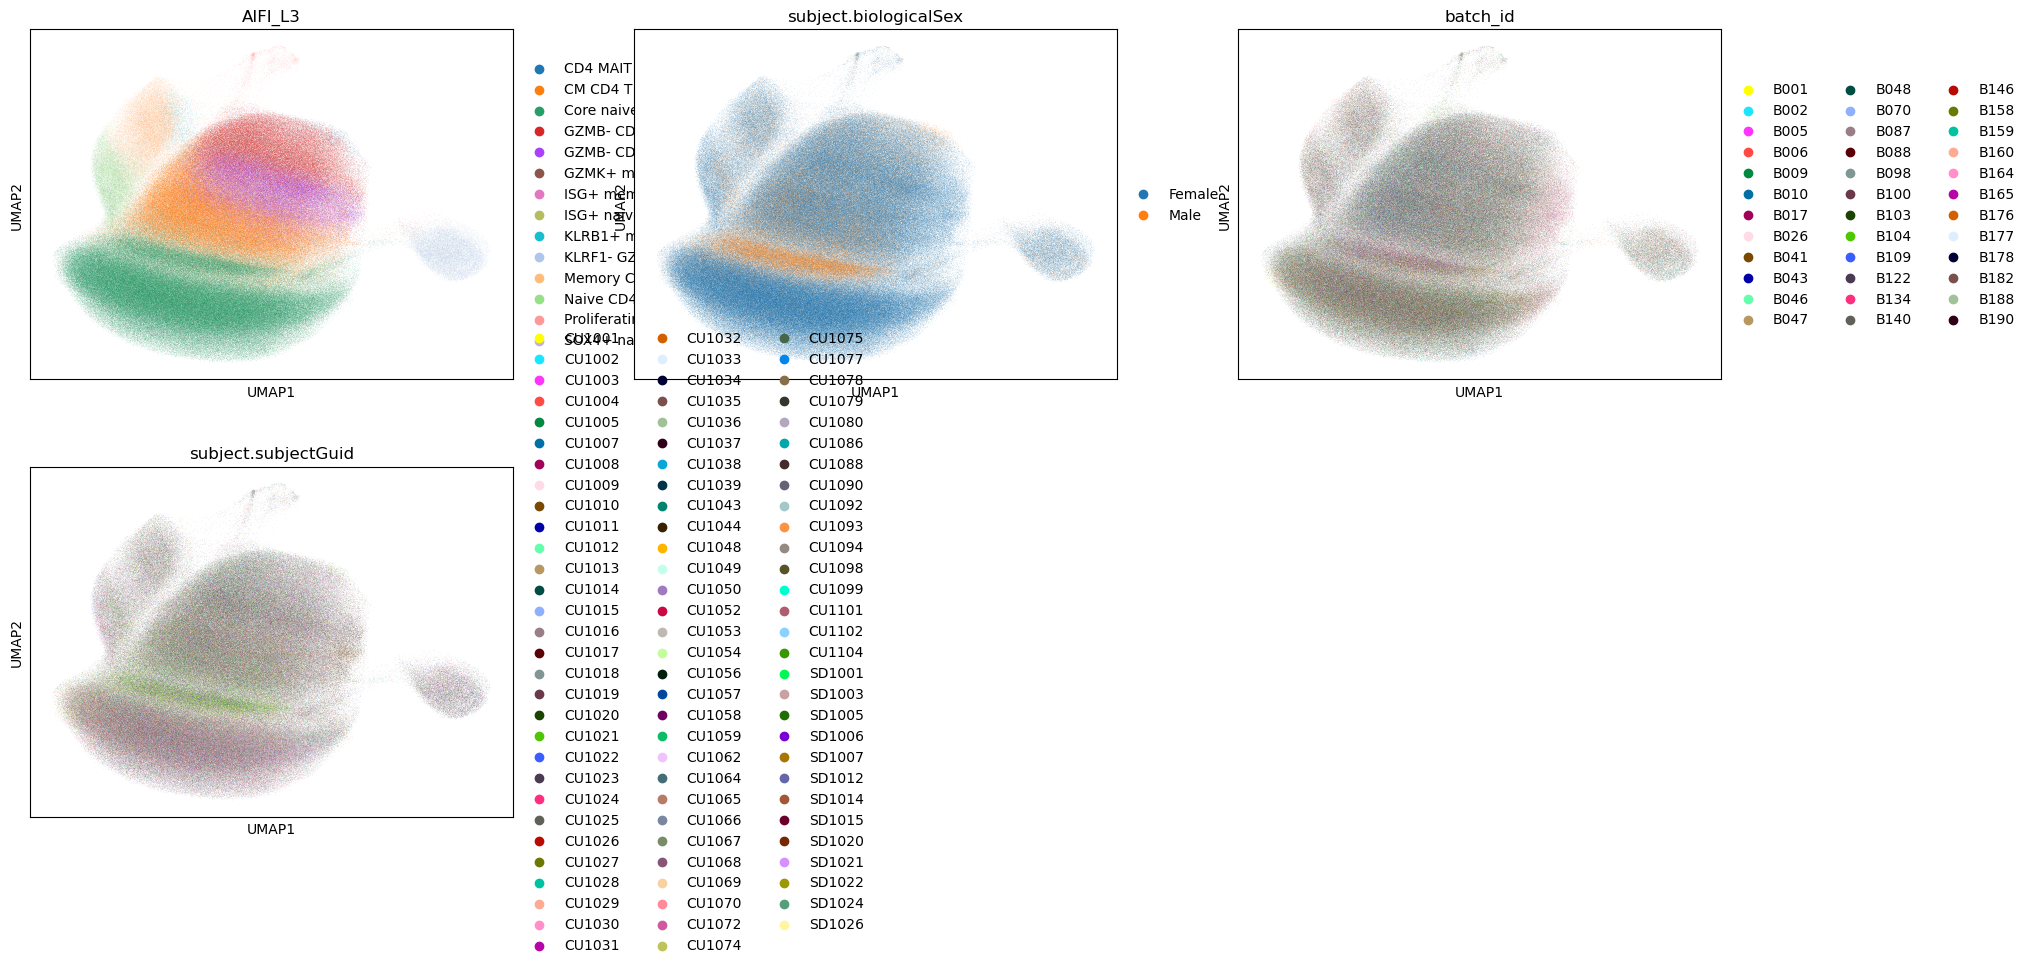

In [14]:
sc.pl.umap(subset_a_dc,color=['AIFI_L3', 
                      'subject.biologicalSex','batch_id','subject.subjectGuid'],ncols=3)

/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/hom

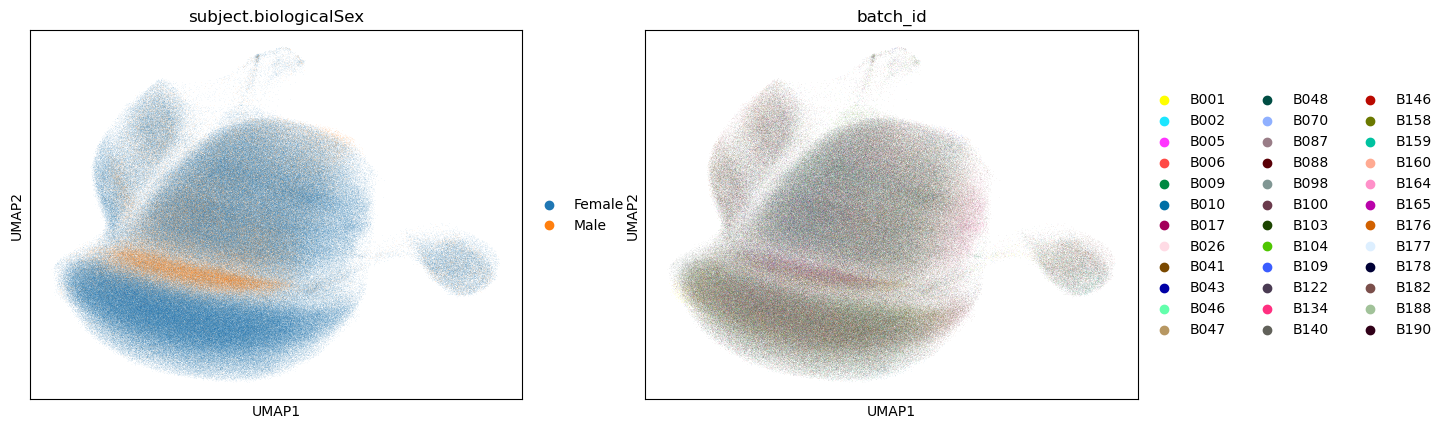

In [16]:
sc.pl.umap(subset_a_dc,color=['subject.biologicalSex','batch_id'],ncols=3)

In [17]:
# Save original PCA and UMAP coordinates
subset_a_dc.obsm['original_X_pca'] = subset_a_dc.obsm['X_pca'].copy()
subset_a_dc.obsm['original_X_umap'] = subset_a_dc.obsm['X_umap'].copy()

In [19]:
subset_a_dc

AnnData object with n_obs × n_vars = 888858 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'well_id', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'sample.visitName', 'sample.drawDate', 'sample.diseaseStatesRecordedAtVisit', 'sample.daysSinceFirstVisit', 'file.id', 'subset_grp', 'predicted_doublet', 'doublet_score', 'AIFI_L1', 'AIFI_L1_score', 'AIFI_L2', 'AIFI_L2_score', 'AIFI_L3', 'AIFI_L3_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden_harmony_2', 'doublets_manual', 'AIFI_L3_new', 'St

In [20]:
# RUN Harmony adjusting for batch and Sex
sce.pp.harmony_integrate(subset_a_dc, ['batch_id', 'subject.biologicalSex'],
                         adjusted_basis='X_pca_harmony')
sc.pp.neighbors(subset_a_dc, n_neighbors=15, n_pcs=30, use_rep='X_pca_harmony',key_added='harmony_neighbors')
sc.tl.umap(subset_a_dc, neighbors_key='harmony_neighbors')

2024-06-27 03:26:24,814 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-06-27 03:29:38,015 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-06-27 03:29:42,379 - harmonypy - INFO - Iteration 1 of 10
2024-06-27 03:38:53,814 - harmonypy - INFO - Iteration 2 of 10
2024-06-27 03:49:30,298 - harmonypy - INFO - Iteration 3 of 10
2024-06-27 04:00:13,677 - harmonypy - INFO - Converged after 3 iterations
IOStream.flush timed out
IOStream.flush timed out


In [21]:
subset_a_dc

AnnData object with n_obs × n_vars = 888858 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'well_id', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'sample.visitName', 'sample.drawDate', 'sample.diseaseStatesRecordedAtVisit', 'sample.daysSinceFirstVisit', 'file.id', 'subset_grp', 'predicted_doublet', 'doublet_score', 'AIFI_L1', 'AIFI_L1_score', 'AIFI_L2', 'AIFI_L2_score', 'AIFI_L3', 'AIFI_L3_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden_harmony_2', 'doublets_manual', 'AIFI_L3_new', 'St

/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/hom

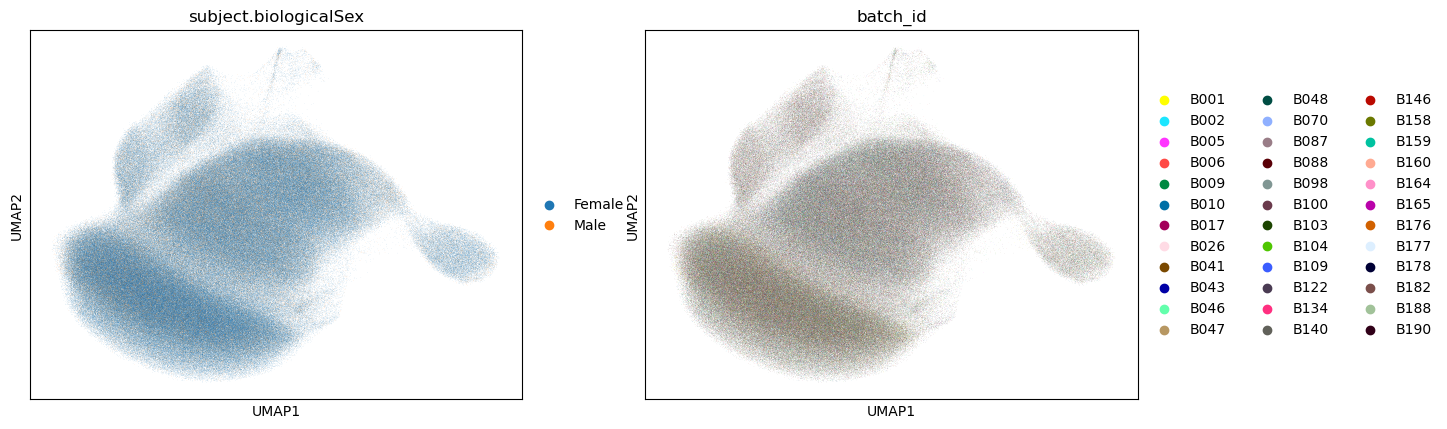

In [23]:
sc.pl.umap(subset_a_dc,color=['subject.biologicalSex','batch_id'],ncols=3)

In [22]:
subset_a_dc.obsm['X_harmony_umap'] = subset_a_dc.obsm['X_umap'].copy()

In [24]:
subset_a_dc.write("/home/jupyter/ALTRA_ANALYSIS/Deep_clean/certpro/py_files/ALTRA_Certpro_CD4_Tcell_harmonized.h5ad")

## NMF projection

# Code Run In Terminal
## due to memory issues
### all the setps are followed as per NMF reference paper Github

In [1]:
%matplotlib inline

# import os
# import pandas as pd
# import numpy as np
# from scipy.io import mmread
# import scipy.sparse as sp
# import matplotlib.pyplot as plt
# from IPython.display import Image
# import scanpy as sc
# #from cnmf import cNMF
# from NMFproj import *

## running NMF on CD4 T cell population

In [2]:

# subset_a_dc=sc.read("/home/jupyter/ALTRA_ANALYSIS/Deep_clean/certpro/py_files/ALTRA_Certpro_CD4_Tcell_harmonized.h5ad")
#subset_a_dc.obs.index = subset_a_dc.obs['barcodes']
# subset_a_dc.obs.index[:10]
#  fixed_W=pd.read_csv("/home/jupyter/ALTRA_ANALYSIS/NMF/reference_files/NMF.W.CD4T.csv") # pre-computed weight matrix from paper
#  fixed_W = fixed_W.rename(columns={'Unnamed: 0': ''})
# fixed_W.set_index(fixed_W.columns[0], inplace=True)
#fixed_W.head()
# X = subset_a_dc.raw.to_adata().to_df().T
#X_norm, X_trunc, df_H, fixed_W_trunc = NMFproj(X, fixed_W, return_truncated=True, normalized=True)
 ## note : UserWarning: input X looks normalized though normalized flag was not passed warnings.warn("input X looks normalized though normalized flag was not passed")
# df_ev = calc_EV(X_trunc, fixed_W_trunc, df_H)
#df_H.iloc[:, :2]
## Rename the index using the mapping
# index_mapping = {
#     'NMF_0': 'NMF0_Cytotoxic',
#     'NMF_1': 'NMF1_Treg',
#     'NMF_2': 'NMF2_Th17',
#     'NMF_3': 'NMF3_Naive',
#     'NMF_4': 'NMF4_Act',
#     'NMF_5': 'NMF5_Th2',
#     'NMF_6': 'NMF6_Tfh',
#     'NMF_7': 'NMF7_IFN',
#     'NMF_8': 'NMF8_Cent_Mem',
#     'NMF_9': 'NMF9_Thymic_Emi',
#     'NMF_10': 'NMF10_Tissue',
#     'NMF_11': 'NMF11_Th1'
# }
#df_H.index = df_H.index.map(index_mapping)
#X.head()
#df_H_norm = (df_H.T / df_H.max(axis=1))
#df_H_norm.head(3)
#subset_a_dc.obs = pd.merge(subset_a_dc.obs, df_H_norm, left_index=True, right_index=True)
#subset_a_dc.write("/home/jupyter/ALTRA_ANALYSIS/Deep_clean/certpro/py_files/ALTRA_Certpro_CD4_Tcell_NMF.h5ad")


# subsetting the Non-naive CD4 T cells from the CD4 T cell population

In [3]:
#subset_a_dc=sc.read("/home/jupyter/ALTRA_ANALYSIS/Deep_clean/certpro/py_files/ALTRA_Certpro_CD4_Tcell_NMF.h5ad")
#AIFI_L3_values_to_remove = ['Core naive CD4 T cell', 'Naive CD4 Treg', 'ISG+ naive CD4 T cell', 'SOX4+ naive CD4 T cell']
#subset_a_dc1 = subset_a_dc[~subset_a_dc.obs['AIFI_L3_new'].isin(AIFI_L3_values_to_remove)]
#subset_a_dc1
#combined_matrix1 = subset_a_dc1.obs[['NMF0_Cytotoxic', 'NMF1_Treg', 'NMF2_Th17', 'NMF4_Act', 'NMF5_Th2','NMF6_Tfh', 'NMF11_Th1']].values
# combined_matrix1
#subset_a_dc1.obsm['NMF_fac_v1']=combined_matrix1
#subset_a_dc1
#sc.pp.neighbors(subset_a_dc1, n_neighbors=15, use_rep='NMF_fac_v1',key_added="NMF_neighbors_v1")
#sc.tl.umap(subset_a_dc1,neighbors_key='NMF_neighbors_v1')
#sc.tl.leiden(subset_a_dc1,resolution=0.5, key_added="leiden_NMF_0.5_v1",n_iterations=2, neighbors_key='NMF_neighbors_v1')
#sc.tl.leiden(subset_a_dc1, key_added="leiden_NMF_v1",n_iterations=2, neighbors_key='NMF_neighbors_v1') ## default resolution "1"
##making the copy of umap 
#subset_a_dc1.obsm['NMF_v1_X_umap'] = subset_a_dc1.obsm['X_umap'].copy()
## Saving the file
#subset_a_dc1.write(/home/jupyter/ALTRA_ANALYSIS/Deep_clean/certpro/py_files/ALTRA_Certpro_CD4_memory_Tcells_NMF.h5ad")